# 1. Import data

In [ ]:
# INSTALL
#!pip install --user xgboost pyod imutils mlxtend

In [1]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import imutils
from pyod.models.iforest import IForest
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.loda import LODA
from pyod.models.vae import VAE
from pyod.models.xgbod import XGBOD
from pyod.models.abod import ABOD
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
def quantify_image(image, bins=(4, 6, 3)):
    # compute a 3D color histogram over the image and normalize it
    hist = cv2.calcHist([image], [0, 1, 2], None, [16, 16, 16],
        [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    # return the histogram
    return hist

In [5]:
images=[]
features = []
PATH = 'GTSRB\Final_Training\Images'
for filename in tqdm(glob.glob(os.path.join(PATH, '*\*.ppm'))):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = imutils.resize(img, width=100)
    images.append(img)

100%|███████████████████████████████████████████████████████████████████████████| 39209/39209 [02:55<00:00, 223.53it/s]


In [6]:
images = np.asarray(images)
images.shape

C:\Users\Carlos\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(39209,)

In [7]:
labels = []
for filename in tqdm(glob.glob(os.path.join(PATH, '*\*.csv'))):
    labels.append(np.genfromtxt(filename, delimiter=';',skip_header=1,dtype='int32'))

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 75.85it/s]


In [8]:
labels = np.vstack(labels)[:,-1]
labels.shape

(39209,)

# 2. Combine data

In [9]:
all_data = np.column_stack((images,labels))

In [10]:
import pandas as pd

df = pd.DataFrame(data=all_data)
df = df.rename(columns={0: "ppm_image", df.columns[-1]: "label"})
df.tail()

,ppm_image,label
39204,"[[[13, 11, 12], [13, 11, 12], [11, 11, 12], [1...",42
39205,"[[[11, 9, 10], [11, 9, 10], [10, 9, 11], [10, ...",42
39206,"[[[10, 10, 12], [11, 11, 13], [12, 12, 14], [1...",42
39207,"[[[14, 13, 15], [14, 13, 15], [13, 13, 15], [1...",42
39208,"[[[10, 9, 11], [10, 9, 11], [10, 9, 11], [10, ...",42


In [11]:
df_stop = df[df.iloc[:,-1] == 14]
df_stop = df_stop.reset_index(drop=True)
df_stop.shape

(780, 2)

In [12]:
features = []
for img in df_stop['ppm_image']:
    features.append(quantify_image(img))
features = np.asarray(features)
df_stop = pd.concat([df_stop, pd.DataFrame(features)], axis=1)
df_stop.shape

(780, 4098)

# 3. Visualize data

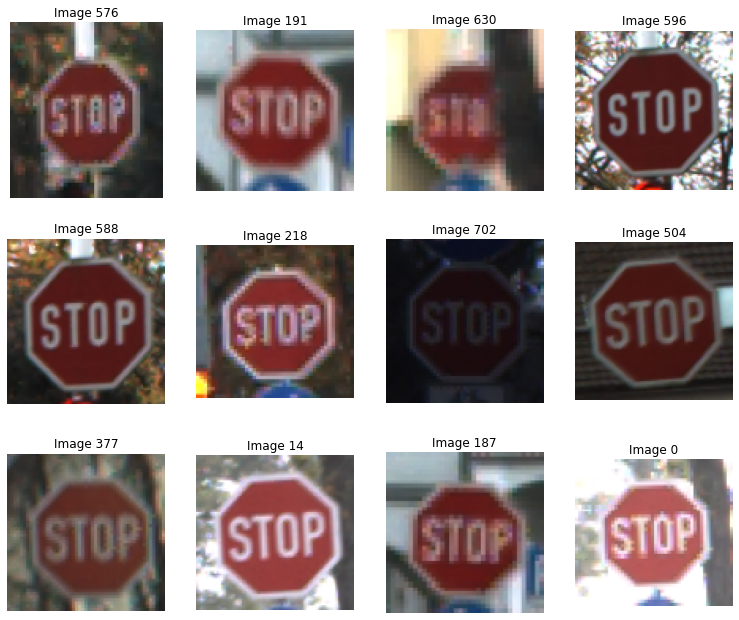

In [13]:
# Show a grid of MxN randomly selected samples from the training data

grid_m = 3
grid_n = 4
rand_grid = np.random.randint(df_stop.shape[0], size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(13,11))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(df_stop['ppm_image'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))
        
plt.savefig('stop_signs.png', dpi=300, bbox_inches='tight')

In [14]:
df_train, df_test = train_test_split(df_stop, test_size=0.15)

print(df_train.shape)
print(df_test.shape)

(663, 4098)
(117, 4098)


In [15]:
df_outliers = df[df['label']==9].sample(10)
df_outliers = df_outliers.append(df[df['label']==17].sample(10))
df_outliers.reset_index(drop=True, inplace=True)
features = []
for img in df_outliers['ppm_image']:
    features.append(quantify_image(img))
features = np.asarray(features)

df_outliers = pd.concat([df_outliers, pd.DataFrame(features)], axis=1)
df_outliers.shape

(20, 4098)

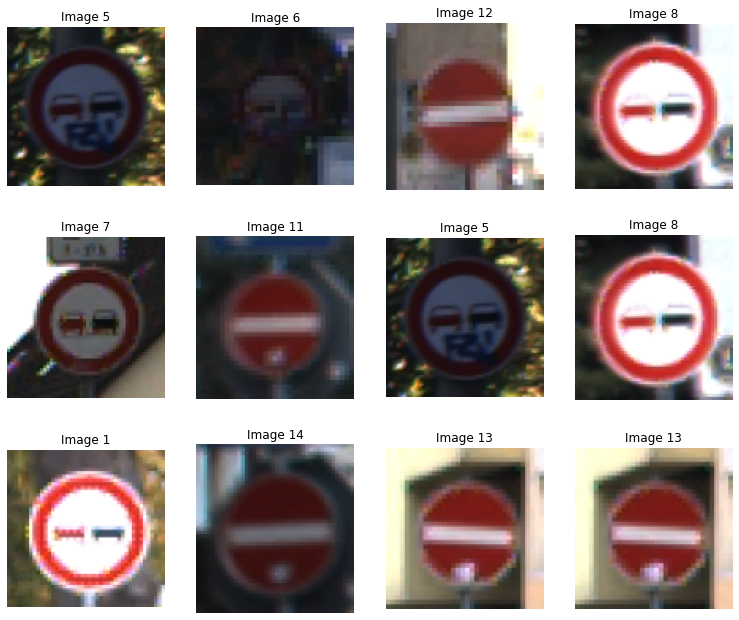

In [16]:
# Show a grid of MxN randomly selected samples from the training data

grid_m = 3
grid_n = 4
rand_grid = np.random.randint(df_outliers.shape[0], size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(13,11))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(df_outliers['ppm_image'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))
        
plt.savefig('outliers.png', dpi=300, bbox_inches='tight')

In [17]:
df_test = df_test.append(df_outliers)
df_test.shape

(137, 4098)

In [18]:
df_train.head()

,ppm_image,label,0,1,2,3,4,5,6,7,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
84,"[[[89, 84, 84], [87, 82, 82], [81, 78, 78], [7...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.002115,0.083894
220,"[[[112, 130, 137], [112, 130, 137], [121, 129,...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00062,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
155,"[[[31, 38, 28], [31, 38, 28], [32, 38, 28], [3...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
337,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.001916,0.000479,0.012692,0.961204
577,"[[[97, 94, 78], [97, 94, 78], [78, 75, 61], [6...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.065636


# 4. Find Optimal Contamination:

In [54]:
true = df_test['label']!=14

## 4.1. Isolation Forest

In [20]:
if_accuracies={}
for x in np.arange(0.01,0.51,0.03):
    model_if = IForest(n_estimators=100, contamination=x, n_jobs=-1, random_state=42)
    model_if.fit(df_train.iloc[:,2:])
    preds_if = model_if.predict(df_test.iloc[:,2:])
    if_accuracies[x] = metrics.f1_score(true, preds_if)

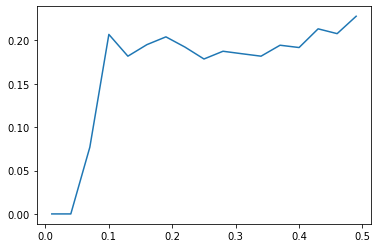

In [21]:
plt.plot(if_accuracies.keys(), if_accuracies.values())

## 4.2. Auto Encoders

In [22]:
ae_accuracies={}
for x in np.arange(0.01,0.51,0.03):
    model_ae = AutoEncoder(epochs=10, random_state=42, contamination=x)
    model_ae.fit(df_train.iloc[:,2:])
    preds_ae = model_ae.predict(df_test.iloc[:,2:])
    ae_accuracies[x] = metrics.f1_score(true, preds_ae)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              16781312  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                262208    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

KeyboardInterrupt: 

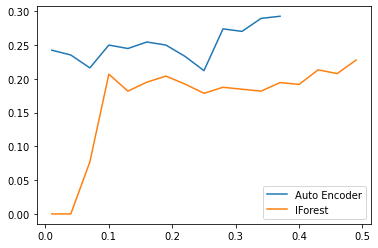

In [23]:
plt.plot(ae_accuracies.keys(), ae_accuracies.values(), label='Auto Encoder')
plt.plot(if_accuracies.keys(), if_accuracies.values(), label='IForest')
plt.legend()
plt.show()

## 4.3. LODA

In [26]:
loda_accuracies={}
for x in np.arange(0.01,0.51,0.03):
    model_loda = LODA(contamination=x, n_bins=10, n_random_cuts=100)
    model_loda.fit(df_train.iloc[:,2:])
    preds_loda = model_loda.predict(df_test.iloc[:,2:])
    loda_accuracies[x] = metrics.f1_score(true, preds_loda)

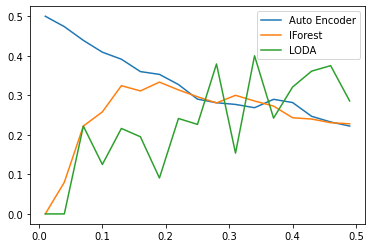

In [27]:
plt.plot(ae_accuracies.keys(), ae_accuracies.values(), label='Auto Encoder')
plt.plot(if_accuracies.keys(), if_accuracies.values(), label='IForest')
plt.plot(loda_accuracies.keys(), loda_accuracies.values(), label='LODA')
plt.legend()
plt.show()

## 4.4. VAE

In [28]:
vae_accuracies={}
for x in np.arange(0.01,0.51,0.03):
    model_vae = VAE(random_state=42, contamination=x, epochs = 10)
    model_vae.fit(df_train.iloc[:,2:])
    preds_vae = model_vae.predict(df_test.iloc[:,2:])
    vae_accuracies[x] = metrics.f1_score(true, preds_vae)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
dense_119 (Dense)               (None, 4096)         16781312    input_1[0][0]                    
__________________________________________________________________________________________________
dense_120 (Dense)               (None, 128)          524416      dense_119[0][0]                  
__________________________________________________________________________________________________
dropout_102 (Dropout)           (None, 128)          0           dense_120[0][0]                  
______________________________________________________________________________________________

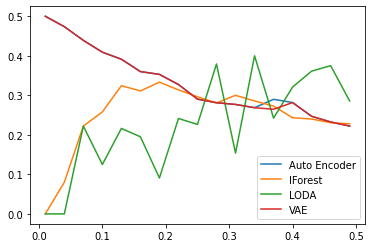

In [29]:
plt.plot(ae_accuracies.keys(), ae_accuracies.values(), label='Auto Encoder')
plt.plot(if_accuracies.keys(), if_accuracies.values(), label='IForest')
plt.plot(loda_accuracies.keys(), loda_accuracies.values(), label='LODA')
plt.plot(vae_accuracies.keys(), vae_accuracies.values(), label='VAE')
plt.legend()
plt.show()

## 4.5. ABOD

In [30]:
abod_accuracies={}
for x in np.arange(0.01,0.51,0.03):
    model_abod = ABOD(contamination=x)
    model_abod.fit(df_train.iloc[:,2:])
    preds_abod = model_abod.predict(df_test.iloc[:,2:])
    abod_accuracies[x] = metrics.f1_score(true, preds_abod)

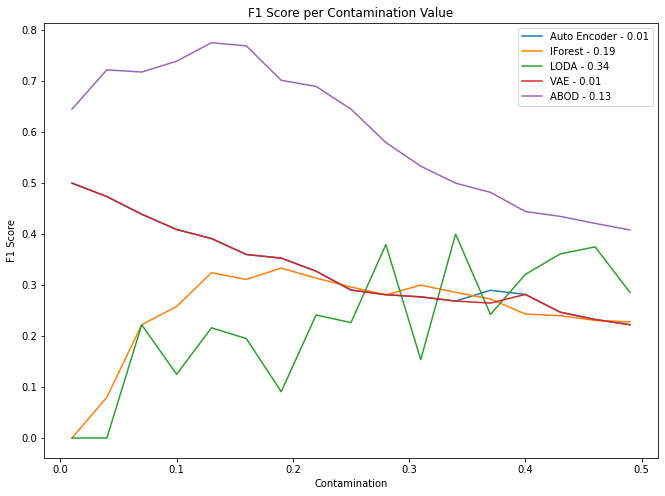

In [233]:
plt.figure(figsize=(11, 8))
plt.plot(ae_accuracies.keys(), ae_accuracies.values(), label='Auto Encoder - {}'.format(round(max(ae_accuracies, key=lambda key: ae_accuracies[key]), 2)))
plt.plot(if_accuracies.keys(), if_accuracies.values(), label='IForest - {}'.format(round(max(if_accuracies, key=lambda key: if_accuracies[key]), 2)))
plt.plot(loda_accuracies.keys(), loda_accuracies.values(), label='LODA - {}'.format(round(max(loda_accuracies, key=lambda key: loda_accuracies[key]), 2)))
plt.plot(vae_accuracies.keys(), vae_accuracies.values(), label='VAE - {}'.format(round(max(vae_accuracies, key=lambda key: vae_accuracies[key]), 2)))
plt.plot(abod_accuracies.keys(), abod_accuracies.values(), label='ABOD - {}'.format(round(max(abod_accuracies, key=lambda key: abod_accuracies[key]), 2)))
plt.legend()
plt.xlabel('Contamination')
plt.ylabel('F1 Score')
plt.title('F1 Score per Contamination Value')
plt.savefig('f1_contamination.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Train and Predict with Optimal Contamination:

In [24]:
max_cont_if = max(if_accuracies, key=lambda key: if_accuracies[key])
max_cont_ae = max(ae_accuracies, key=lambda key: ae_accuracies[key])
max_cont_vae = max(vae_accuracies, key=lambda key: vae_accuracies[key])
max_cont_loda = max(loda_accuracies, key=lambda key: loda_accuracies[key])
max_cont_abod = max(abod_accuracies, key=lambda key: abod_accuracies[key])

NameError: name 'vae_accuracies' is not defined

In [33]:
print('IForest optimal contamination: {:.2f}'.format(max_cont_if))
print('Auto Encoder optimal contamination: {:.2f}'.format(max_cont_ae))
print('VAE optimal contamination: {:.2f}'.format(max_cont_vae))
print('LODA optimal contamination: {:.2f}'.format(max_cont_loda))
print('ABOD optimal contamination: {:.2f}'.format(max_cont_abod))

IForest optimal contamination: 0.19
Auto Encoder optimal contamination: 0.01
VAE optimal contamination: 0.01
LODA optimal contamination: 0.34
ABOD optimal contamination: 0.13


In [26]:
model_if = IForest(n_estimators=100, contamination=0.19, n_jobs=-1, random_state=42)
model_ae = AutoEncoder(epochs=10, random_state=42, contamination=0.01)
model_vae = VAE(random_state=42, contamination=0.01, epochs = 10)
model_loda = LODA(contamination=0.34, n_bins=10, n_random_cuts=100)
model_abod = ABOD(contamination=0.13)

In [27]:
model_if.fit(df_train.iloc[:,2:])
model_ae.fit(df_train.iloc[:,2:])
model_vae.fit(df_train.iloc[:,2:])
model_loda.fit(df_train.iloc[:,2:])
model_abod.fit(df_train.iloc[:,2:])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_84 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_99 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_85 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_100 (Dense)            (None, 64)                262208    
_________________________________________________________________
dropout_86 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 32)              

ABOD(contamination=0.13, method='fast', n_neighbors=5)

In [28]:
preds_if = model_if.predict(df_test.iloc[:,2:])
proba_preds_if = model_if.predict_proba(df_test.iloc[:,2:])[:,1]

preds_ae = model_ae.predict(df_test.iloc[:,2:])
proba_preds_ae = model_ae.predict_proba(df_test.iloc[:,2:])[:,1]

preds_vae = model_vae.predict(df_test.iloc[:,2:])
proba_preds_vae = model_vae.predict_proba(df_test.iloc[:,2:])[:,1]

preds_loda = model_loda.predict(df_test.iloc[:,2:])
proba_preds_loda = model_loda.predict_proba(df_test.iloc[:,2:])[:,1]

preds_abod = model_abod.predict(df_test.iloc[:,2:])
proba_preds_abod = model_abod.predict_proba(df_test.iloc[:,2:])[:,1]

# 6. Evaluate:

In [29]:
import math
def calc_error(y_true, y_pred):
    error = sum(((y_true == 1) & (y_pred == 0))) / sum(y_true)
    return error

def calc_conf_interval(score, n=df_test.shape[0], const=1.96):
    lower_bound = score - const * math.sqrt( (score * (1 - score)) / n)
    upper_bound = score + const * math.sqrt( (score * (1 - score)) / n)
    
    return lower_bound, upper_bound

## 6.1. F1-score with Confidence Interval:

In [30]:
f1_if = metrics.f1_score(true, preds_if)
f1_ae = metrics.f1_score(true, preds_ae)
f1_vae = metrics.f1_score(true, preds_vae)
f1_loda = metrics.f1_score(true, preds_loda)
f1_abod = metrics.f1_score(true, preds_abod)

In [31]:
print('IForest score: {:.2f}'.format(float(f1_if)))
print('AE score: {:.2f}'.format(float(f1_ae)))
print('LODA score: {:.2f}'.format(float(f1_vae)))
print('VAE score: {:.2f}'.format(float(f1_loda)))
print('ABOD score: {:.2f}'.format(float(f1_abod)))

IForest score: 0.20
AE score: 0.24
LODA score: 0.24
VAE score: 0.25
ABOD score: 0.74


In [32]:
f1_conf_if = calc_conf_interval(f1_if)
f1_conf_ae = calc_conf_interval(f1_ae)
f1_conf_vae = calc_conf_interval(f1_vae)
f1_conf_loda = calc_conf_interval(f1_loda)
f1_conf_abod = calc_conf_interval(f1_abod)

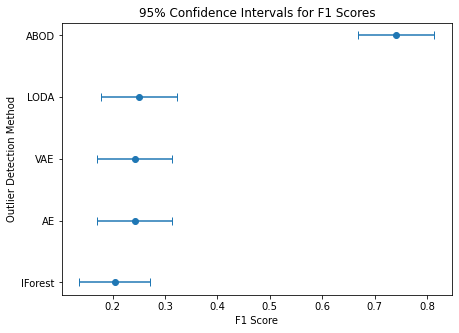

In [33]:
from scipy import stats

plt.figure(figsize=(7, 5))

scores_list = [f1_if, f1_ae, f1_vae, f1_loda, f1_abod]
W_list = np.array([f1_conf_if, f1_conf_ae, f1_conf_vae, f1_conf_loda, f1_conf_abod])

plt.errorbar(x=scores_list, y=range(len(scores_list)), xerr=scores_list-W_list[:,0], fmt='o', capsize=4)
plt.yticks(ticks=[0, 1, 2, 3, 4], labels=['IForest', 'AE', 'VAE', 'LODA', 'ABOD'])
plt.xlabel('F1 Score')
plt.ylabel('Outlier Detection Method')
plt.title('95% Confidence Intervals for F1 Scores')
plt.savefig('f1_conf_interval.png', bbox_inches='tight', dpi=300)
plt.show();

## 6.2. Error with Confidence Interval:

In [34]:
error_if = calc_error(true, preds_if)
error_ae = calc_error(true, preds_ae)
error_vae = calc_error(true, preds_vae)
error_loda = calc_error(true, preds_loda)
error_abod = calc_error(true, preds_abod)

In [35]:
err_conf_if = calc_conf_interval(error_if)
err_conf_ae = calc_conf_interval(error_ae)
err_conf_vae = calc_conf_interval(error_vae)
err_conf_loda = calc_conf_interval(error_loda)
err_conf_abod = calc_conf_interval(error_abod)

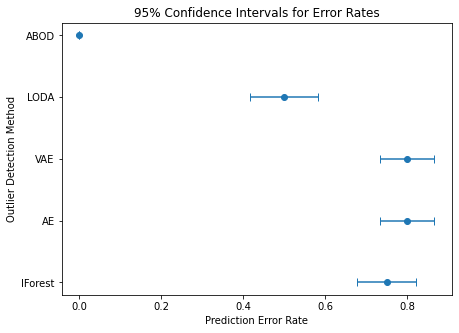

In [36]:
plt.figure(figsize=(7, 5))

scores_list = [error_if, error_ae, error_vae, error_loda, error_abod]
W_list = np.array([err_conf_if, err_conf_ae, err_conf_vae, err_conf_loda, err_conf_abod])

plt.errorbar(x=scores_list, y=range(len(scores_list)), xerr=scores_list-W_list[:,0], fmt='o', capsize=4)
plt.yticks(ticks=[0, 1, 2, 3, 4], labels=['IForest', 'AE', 'VAE', 'LODA', 'ABOD'])
plt.xlabel('Prediction Error Rate')
plt.ylabel('Outlier Detection Method')
plt.title('95% Confidence Intervals for Error Rates')
plt.savefig('err_conf_interval.png', bbox_inches='tight', dpi=300)
plt.show();

## 6.3. ROC-AUC:

In [37]:
fpr_if, tpr_if, threshold_if = metrics.roc_curve(true, model_if.predict_proba(df_test.iloc[:,2:])[:,1])
fpr_ae, tpr_ae, threshold_ae = metrics.roc_curve(true, model_ae.predict_proba(df_test.iloc[:,2:])[:,1])
fpr_loda, tpr_loda, threshold_loda = metrics.roc_curve(true, model_loda.predict_proba(df_test.iloc[:,2:])[:,1])
fpr_vae, tpr_vae, threshold_vae = metrics.roc_curve(true, model_vae.predict_proba(df_test.iloc[:,2:])[:,1])
fpr_abod, tpr_abod, threshold_abod = metrics.roc_curve(true, model_abod.predict_proba(df_test.iloc[:,2:])[:,1])

roc_auc_if = metrics.auc(fpr_if, tpr_if)
roc_auc_ae = metrics.auc(fpr_ae, tpr_ae)
roc_auc_loda = metrics.auc(fpr_loda, tpr_loda)
roc_auc_vae = metrics.auc(fpr_vae, tpr_vae)
roc_auc_abod = metrics.auc(fpr_abod, tpr_abod)

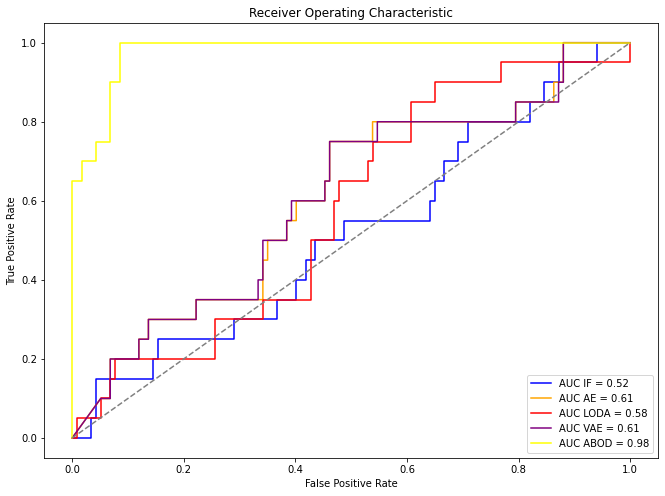

In [38]:
plt.figure(figsize=(11, 8))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_if, tpr_if, 'b', color = 'blue', label = 'AUC IF = %0.2f' % roc_auc_if)
plt.plot(fpr_ae, tpr_ae, 'b', color = 'orange', label = 'AUC AE = %0.2f' % roc_auc_ae)
plt.plot(fpr_loda, tpr_loda, 'b', color = 'red', label = 'AUC LODA = %0.2f' % roc_auc_loda)
plt.plot(fpr_vae, tpr_vae, 'b', color = 'purple', label = 'AUC VAE = %0.2f' % roc_auc_vae)
plt.plot(fpr_abod, tpr_abod, 'b', color = 'yellow', label = 'AUC ABOD = %0.2f' % roc_auc_abod)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color = 'grey')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc_auc.png', dpi=300, bbox_inches='tight')
plt.show()

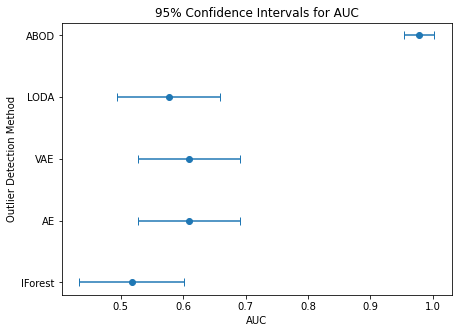

In [39]:
plt.figure(figsize=(7, 5))

scores_list = [roc_auc_if, roc_auc_ae, roc_auc_vae, roc_auc_loda, roc_auc_abod]
W_list = np.array([calc_conf_interval(x) for x in scores_list])

plt.errorbar(x=scores_list, y=range(len(scores_list)), xerr=scores_list-W_list[:,0], fmt='o', capsize=4)
plt.yticks(ticks=[0, 1, 2, 3, 4], labels=['IForest', 'AE', 'VAE', 'LODA', 'ABOD'])
plt.xlabel('AUC')
plt.ylabel('Outlier Detection Method')
plt.title('95% Confidence Intervals for AUC')
plt.savefig('auc_conf_interval.png', bbox_inches='tight', dpi=300)
plt.show()

## 6.4. Confusion Matrices:

In [41]:
from mlxtend.plotting import plot_confusion_matrix
grid_m = 2
grid_n = 3

fig = plt.figure(figsize=(12,10))
fig.tight_layout()
axes = [plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig),
        plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig),
        plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig),
        plt.subplot2grid((2,6), (1,1), colspan=2, fig=fig),
        plt.subplot2grid((2,6), (1,3), colspan=2, fig=fig)]

models = [model_if, model_ae, model_vae, model_loda, model_abod]
all_preds = [preds_if, preds_ae, preds_vae, preds_loda, preds_abod]
cm = [metrics.confusion_matrix(true, pred) for pred in all_preds]
names = ['IForest', 'Auto Encoder', 'VAE', 'LODA', 'ABOD']

for i in range(len(models)):
    fig, ax = plot_confusion_matrix(conf_mat=cm[i], show_normed=True,
                                    show_absolute=False, axis=axes[i], figure=fig)
    axes[i].set_title('{}'.format(names[i]))
    axes[i].set_xlabel('predicted label')
    axes[i].set_ylabel('true label')
fig.subplots_adjust(wspace=2, hspace=-0.3)
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

ModuleNotFoundError: No module named 'mlxtend'

# 7. Significance Test:

## 7.1. IF-ABOD:

In [82]:
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import mcnemar

tb_if_abod = mcnemar_table(y_target=true, 
                   y_model1=preds_if, 
                   y_model2=preds_abod)

chi2_if_abod, p_if_abod = mcnemar(ary=tb_if_abod, corrected=True)

p_if_abod

0.000252249023327326

## 7.2. ABOD-AE:

In [85]:
tb_abod_ae = mcnemar_table(y_target=true, 
                   y_model1=preds_abod, 
                   y_model2=preds_ae)

chi2_abod_ae, p_abod_ae = mcnemar(ary=tb_abod_ae, corrected=True)

p_abod_ae

0.08172275229865922

## 7.3. ABOD-VAE:

In [86]:
tb_abod_vae = mcnemar_table(y_target=true, 
                   y_model1=preds_abod, 
                   y_model2=preds_vae)

chi2_abod_vae, p_abod_vae = mcnemar(ary=tb_abod_vae, corrected=True)

p_abod_vae

0.08172275229865922

## 7.4. ABOD-LODA:

In [87]:
tb_abod_loda = mcnemar_table(y_target=true, 
                   y_model1=preds_abod, 
                   y_model2=preds_loda)

chi2_abod_loda, p_abod_loda = mcnemar(ary=tb_abod_loda, corrected=True)

p_abod_loda

4.3651695094350006e-10

## 7.5. AE-VAE:

In [96]:
tb_ae_vae = mcnemar_table(y_target=true, 
                   y_model1=preds_ae, 
                   y_model2=preds_vae)

chi2_ae_vae, p_ae_vae = mcnemar(ary=tb_ae_vae, exact=True)

p_ae_vae

1.0

## 7.6. AE-LODA:

In [97]:
tb_ae_loda = mcnemar_table(y_target=true, 
                   y_model1=preds_ae, 
                   y_model2=preds_loda)

chi2_ae_loda, p_ae_loda = mcnemar(ary=tb_ae_loda, corrected=True)

p_ae_loda

3.0081996027065376e-06

## 7.7. AE-IF:

In [98]:
tb_ae_if = mcnemar_table(y_target=true, 
                   y_model1=preds_ae, 
                   y_model2=preds_if)

chi2_ae_if, p_ae_if = mcnemar(ary=tb_ae_if, corrected=True)

p_ae_if

0.005577994003398252

## 7.8. VAE-LODA:

In [99]:
tb_vae_loda = mcnemar_table(y_target=true, 
                   y_model1=preds_vae, 
                   y_model2=preds_loda)

chi2_vae_loda, p_vae_loda = mcnemar(ary=tb_vae_loda, corrected=True)

p_vae_loda

3.0081996027065376e-06

## 7.9. VAE-IF:

In [101]:
tb_vae_if = mcnemar_table(y_target=true, 
                   y_model1=preds_vae, 
                   y_model2=preds_if)

chi2_vae_if, p_vae_if = mcnemar(ary=tb_vae_if, corrected=True)

p_vae_if

0.005577994003398252

## 7.10. LODA-IF:

In [104]:
tb_loda_if = mcnemar_table(y_target=true, 
                   y_model1=preds_loda, 
                   y_model2=preds_if)

chi2_loda_if, p_loda_if = mcnemar(ary=tb_loda_if, corrected=True)

p_loda_if

0.0035307619178311742